# Module 4: Calculus & Differential Equations

---

# Day 2: Differential equations exercises

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.linalg as lin
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

## 1. LIF model with time-varying input current

In our lecture example of the LIF model, we used a constant $I_{input}$ for simplicity and to allow for a tractable analytical solution. However, the problem becomes much more interesting when $I_{input}$ also varies with time, such that:

$$
C \frac{dV}{dt} = (E_\text{leak} - V) \frac{1}{R} + I(t)
$$

Assuming $RC = 20 ms$, $E_{leak} = -70 mV$, and $V_0 = -70 mV$, use Euler's method with stepsize $1 ms$ to model the above differential equation from $t = 0$ to $t = 1 s$ with the following input currents:

1. $I(t)$ is a step-function, where $I(t) = 1000C$ amps for $250$ ms $< t < 750$ ms and $I(t) = 0$ everywhere else.
2. $I(t) = I_0\sin(\omega t)$, where $I_0 = 1000C$ amps and angular frequency $\omega = 10$

**Note:** Don't think too hard about the $C$ in the input current functions -- this is just to "cancel out" the $C$ in the differential equation when it gets moved to the right side (i.e. just use ``1000`` and not ``1000*C`` in your code).

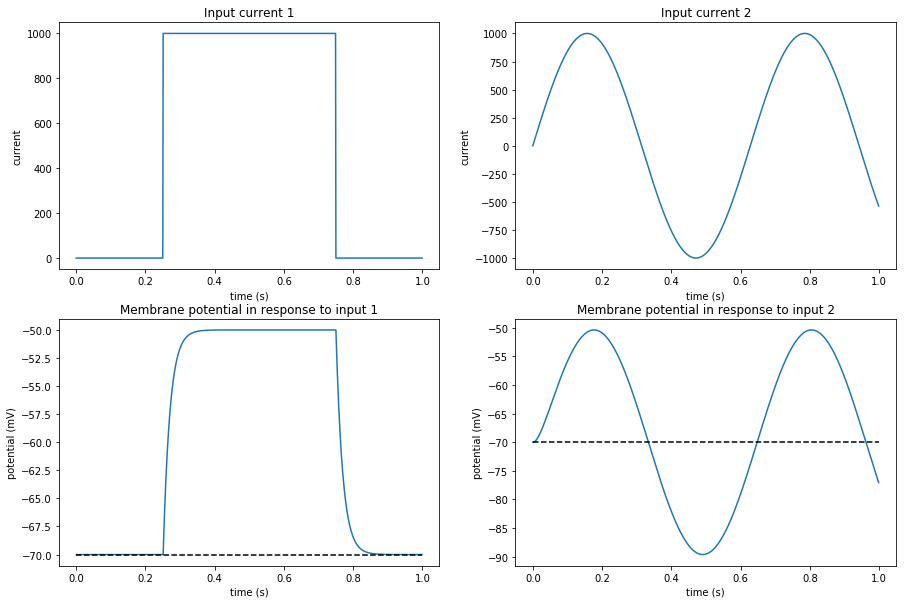

In [2]:
# initialize constants
RC = 0.02
E_leak = -70
V_init = -70

# 1. make a function for the input current
# step function
def I_in1(t):
    if (t>0.25) & (t<0.75):  
        return 1000       
    else:
        return 0
    
# sinusoid      
def I_in2(t):
    return 1000*np.sin(10*t)
            

# 2. function for membrane potential dynamics
# I'm using 'i' to indicate which input current to use
def dV_dt(V,t,i):
    if i==1:
        return (E_leak-V)/RC + I_in1(t)
    elif i==2:
        return (E_leak-V)/RC + I_in2(t)
    else:
        return 0


# 3. apply Euler's method   
h = 0.001   # stepsize
t = np.arange(0,1,h)
V_em1 = np.zeros_like(t) # for the step function
V_em2 = np.zeros_like(t) # for the sinusoid
N = np.size(t)
V_em1[0] = V_init
V_em2[0] = V_init
for n in np.arange(1,N):
    V_em1[n] = h*dV_dt(V_em1[n-1],t[n-1],1) + V_em1[n-1]
    V_em2[n] = h*dV_dt(V_em2[n-1],t[n-1],2) + V_em2[n-1]
    
    
# 4. plot results
# include a plot for both the membrane potential and the input current
_, axs = plt.subplots(2,2,figsize=(15,10))

# input current 1
I1_plot = [I_in1(i) for i in t]
axs[0,0].plot(t,I1_plot)
axs[0,0].set_title("Input current 1");
axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("current");

# membrane potential to input 1
axs[1,0].plot(t,V_em1)
axs[1,0].plot(t,E_leak*np.ones_like(t),'k--')
axs[1,0].set_title("Membrane potential in response to input 1");
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("potential (mV)");

# input current 2
axs[0,1].plot(t,I_in2(t))
axs[0,1].set_title("Input current 2");
axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("current");

# membrane potential to input 2
axs[1,1].plot(t,V_em2)
axs[1,1].plot(t,E_leak*np.ones_like(t),'k--')
axs[1,1].set_title("Membrane potential in response to input 2");
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel("potential (mV)");

Next, plot slope fields for $\frac{dV}{dt}$ separately for each input current using the intervals $t = [0,1] s$ and $V = [-100, -30] mV$. Use 20 samples in each dimension.

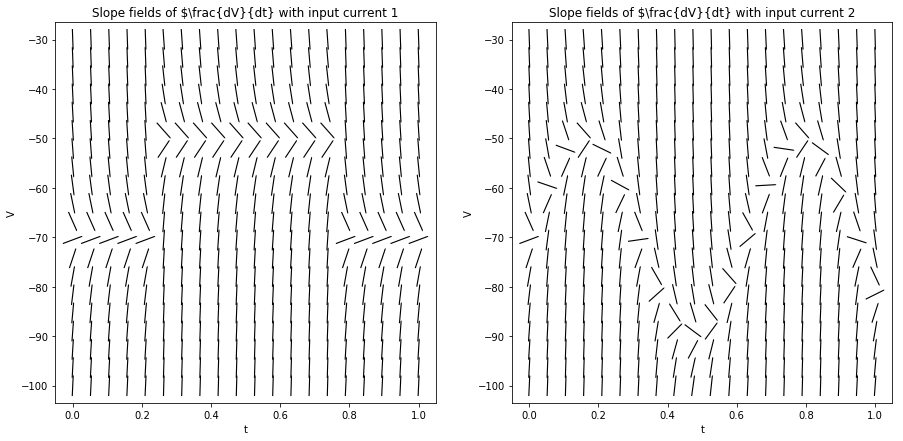

In [3]:
_, axs = plt.subplots(1,2,figsize=(15,7))

# 1. define sample points to compute the slopes
t = np.linspace(0,1,20)
V = np.linspace(-100,-30,20)

# 2. iterate over points to plot the slopes and create the slope field
for j in t:
    for k in V:
        slope1 = dV_dt(k,j,1)
        slope2 = dV_dt(k,j,2)
        axs[0].quiver(j,k,1,slope1,angles='xy',width=0.003,headwidth=1,headlength=1,pivot='mid')
        axs[1].quiver(j,k,1,slope2,angles='xy',width=0.003,headwidth=1,headlength=1,pivot='mid')
        
axs[0].set_title(r"Slope fields of $\frac{dV}{dt} with input current 1");
axs[0].set_xlabel("t")
axs[0].set_ylabel("V");
axs[1].set_title(r"Slope fields of $\frac{dV}{dt} with input current 2");
axs[1].set_xlabel("t")
axs[1].set_ylabel("V");


## 2. Drift-diffusion model
Another commmon dynamical system that's studied in neuroscience is known as the *drift-diffusion model*. The drift-diffusion model is applied to tasks involving *evidence accumulation* towards one of two available choices. One such task is known as the *towers task*, where mice run down a virtual hallway counting towers that appear to its left and right. The side with the higher number of towers by the end of the hallway corresponds to the correct choice, where if the mouse turns to the side with more towers, it will collect reward. A visualization of what this task looks like to the mouse is shown below (from Engelhard et al., 2019, *Nature*).

In [4]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="60%" controls>
      <source src="41586_2019_1261_MOESM2_ESM.mp4" type="video/mp4">
</video></div>""")

The drift-diffusion model describes how a decision variable $C$ changes in response to evidence $v$ you're accumulating over time. This starts with a very simple differential equation:

$$
\frac{dC}{dt} = v
$$

This can be solved by integrating the equation:

$$
dC = vdt
$$

For the towers task, $v$ is something like a step function, with positive steps corresponding to towers on the left and negative steps corresponding to towers on the right. Integrating these steps over time gives you a decision variable $C$, which will bias the mouse towards the left if positive, and bias the mouse towards the right if negative. However, this is *not* the full drift-diffusion model. This is more like a *drift* model; where does the *diffusion* come in? You can imagine that mice, as well as most animals, are not going to be perfect in their counting of the towers. They might get distracted and miss some, or forget how many they have seen half way through, or mistake something for a tower that didn't actually appear. To account for this, we need to add in a *diffusion* term that adds noise to the evidence accumulation. This can be done by adding a random variable drawn from a Gaussian:

$$
dC = vdt + wN(0,1)
$$

where $w$ is the weight of the diffusion, or how strongly it influences the decision variable. You may be wondering: why isn't the diffusion term included in the integral? This is because the animal isn't *accumulating* the noise -- it's merely affecting the evidence independently and randomply at each time step. Because of this, when applying Euler's method, the noise term will be *excluded* from the slope function and instead added at the end.

Lets start by approximating the decision variable $C$ with constant evidence $v = 1$ and noise weight $w = 0.7$. Use $dt = 0.02 s$ and $C(0) = 0$, and approximate the model out to $5$ seconds. Run this at least 5 times and plot the results together.

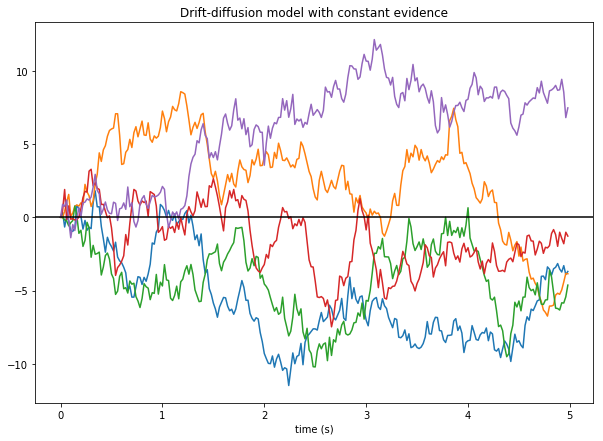

In [5]:
# initialize variables
v = 1
w = 0.7
dt = 0.02
t_trial = 5
t = np.arange(0,t_trial,dt)
N = np.size(t)

# 1. use Euler's method to approximate C
# tip: use a for loop to store C for multiple iterations
plt.figure(figsize=(10,7))
C = np.zeros((5,N))        # initialize C for 5 iterations
for i in np.arange(5):
    for n in np.arange(1,N):
        # now the only variable contributing to the slope is v -- the noise gets added at the end
        C[i,n] = v*dt +  C[i,n-1] + w*np.random.randn(1)
        
    plt.plot(t,C[i,:])

    
# 2. plot results
plt.axhline(y=0, color='k')
plt.title('Drift-diffusion model with constant evidence')
plt.xlabel('time (s)')
plt.show()

You may notice that the model will continue accumulating indefinitely; oftentimes, the model contains some bound that signifies when sufficient evidence has been accumulated and a decision can be made. You'll learn more about this in your core courses.

What if the evidence $v$ varied with time? Repeat the above simulation but this time have $v$ vary randomly across timesteps according to $v = 0.5 + N(0,1)$

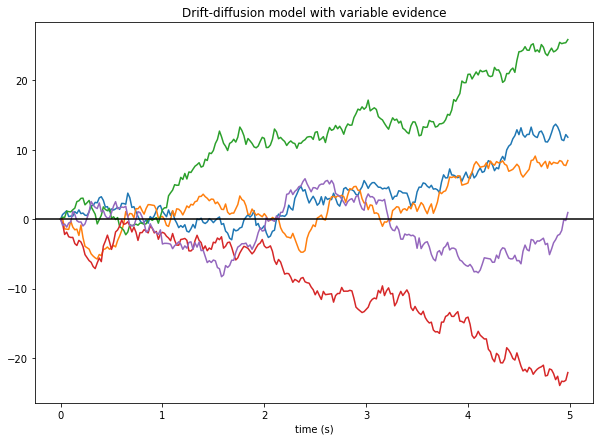

In [6]:
# initialize variables
w = 0.7
dt = 0.02
t_trial = 5
t = np.arange(0,t_trial,dt)
N = np.size(t)

# 1. use Euler's method to approximate C
# tip: use a for loop to store C for multiple iterations
plt.figure(figsize=(10,7))
C = np.zeros((5,N))
for i in np.arange(5):
    for n in np.arange(1,N):
        # we don't need to define a function for v since it does not depend on t; however, it needs to get re-defined at each time point
        v = 0.5 + np.random.randn(1)
        C[i,n] = v*dt + C[i,n-1] + w*np.random.randn(1)
        
    plt.plot(t,C[i,:])

    
# 2. plot results
plt.axhline(y=0, color='k')
plt.title('Drift-diffusion model with variable evidence')
plt.xlabel('time (s)')
plt.show()

What if $v$ were a function, like a step function corresponding to towers in the towers task? See if you can think of a way to model the stimulus of this task as a step function with ones corresponding to left towers and negative ones corresponding to right towers. Here are some tips that might help you:
1. Think of each simulation as a single trial. We'll assume that a trial lasts $20$ seconds, and we want to sample every $0.02$s (i.e. $dt = 0.02$)
2. The towers on the "high" side should be chosen as a poisson random variable with $\lambda=6$, and the number of towers on the "low" side should be chosen with $\lambda=2$. The high side (either left or right) should be chosen randomly at the beginning of the trial.
3. We want each tower to be "in view" for $1$ second. In other words, pad a zeros vector with ones for $1$ s ($1/dt = 50$ samples) for left towers and negative ones for right towers
4. The towers on each side should be randomly placed throughout the trial with no overlap and no co-occurance of left and right towers. 

**Note:** There is no "right" way to define this stimulus; there are a lot of methods that can produce the same stimulus. 

Once you have the stimulus defined, use this as you evidence $v$ that is being accumulated throughout the trial. Use Euler's method to approximate the decision variable $C$ with $C_0 = 0$ using the same $dt = 0.02$ and noise weight $w = 0.05$. Plot both the towers stimulus and the decision variable on separate plots.

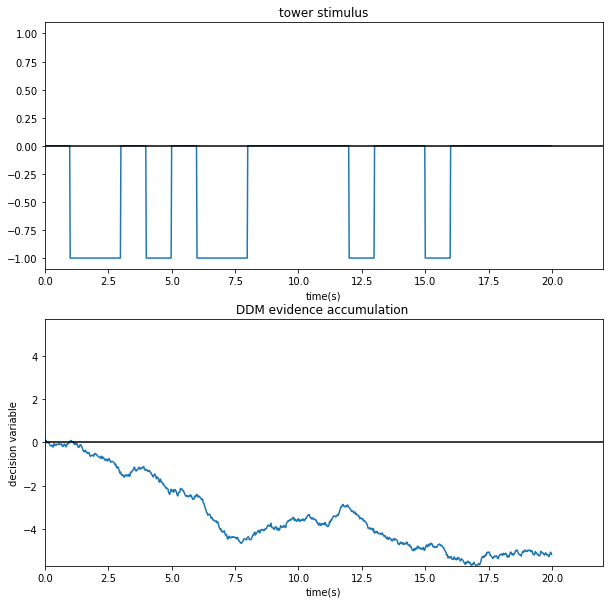

In [7]:
# define variables
dt = 0.02
t_trial = 20
t = np.arange(0,t_trial,dt)

# 1. function for evidence
# get the number of towers for each side
n_high = np.random.poisson(6)   # high-side towers
n_low = np.random.poisson(2)    # low-side towers
n_empty = t_trial-n_high-n_low  # pad the rest of the slots with zeros

# randomly place each tower throughout the trial 
locs = np.arange(t_trial)   # treat the trial as 20 1-s blocks, 
cue_locs = np.random.choice(locs,n_high+n_low,False) # choose random locations for the towers

stim = np.zeros_like(t)              # initialize the stimulus as a bunch of zeros
side_high = np.random.choice([-1,1]) # randomly assign which side is the "high" side
for n in np.arange(n_high+n_low):
    # get the inds for the block 
    inds = np.arange(int(cue_locs[n]*1/dt),int(cue_locs[n]*1/dt)+int(1/dt))
    if n<n_high:
        stim[inds] = side_high       # assign the first set of locs to the high side
    else:
        stim[inds] = -1*side_high    # assign the remaining locs to the low side

# 2. use Euler's method to approximate the decision variable
w = 0.05
C = np.zeros_like(t)
N = np.size(t)
for n in np.arange(1,N):
    C[n] = stim[n-1]*dt + w*np.random.randn(1) + C[n-1]

# 3. plot results
_,axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(t,stim)
axs[0].axhline(y=0, color='k')
axs[0].axis([0,22,-1.1,1.1])
axs[0].set_xlabel('time(s)');
axs[0].set_title('tower stimulus')
axs[1].plot(t,C)
axs[1].axhline(y=0, color='k')
axs[1].axis([0,22,-np.max(np.abs(C)),np.max(np.abs(C))])
axs[1].set_xlabel('time(s)');
axs[1].set_ylabel('decision variable');
axs[1].set_title('DDM evidence accumulation ');

You can interpret the sign of the decision variable at the end as the *choice* the agent will make, and the magnitude of the decision variable is proportional to the *confidence* of the agent in their choice. How often is the drift-diffusion model making the correct choice?